<a href="https://colab.research.google.com/github/seriamedard/ASL_ResNet/blob/main/ASL_dev_local_50e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import layers, models, utils, callbacks
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  load_img, img_to_array)
from sklearn.metrics import (classification_report, accuracy_score,precision_score,
                             recall_score,confusion_matrix,roc_curve,roc_auc_score,
                             confusion_matrix)  

#Preprocessing


In [ ]:
# Download data from kaggle using username and api key
#od.download("https://www.kaggle.com/datasets/grassknoted/asl-alphabet")

100%|██████████| 1.03G/1.03G [07:08<00:00, 2.57MB/s]


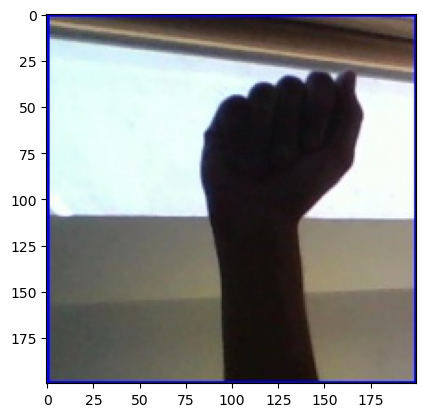

In [ ]:
# Test plot images
img=cv2.imread('./asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg')
img2 = img[:,:,::-1]
plt.imshow(img2)

In [ ]:
# Create Labels with contents

train_folder = './asl-alphabet//asl_alphabet_train/asl_alphabet_train'

all_data = []
for folder in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)


In [ ]:
data_df.head

<bound method NDFrame.head of       label                                               path
0         A  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
1         A  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
2         A  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
3         A  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
4         A  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
...     ...                                                ...
86995     Z  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
86996     Z  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
86997     Z  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
86998     Z  ./asl-alphabet//asl_alphabet_train/asl_alphabe...
86999     Z  ./asl-alphabet//asl_alphabet_train/asl_alphabe...

[87000 rows x 2 columns]>

In [ ]:
labels = data_df['label'].unique()

array(['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
       'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U',
       'V', 'W', 'X', 'Y', 'Z'], dtype=object)

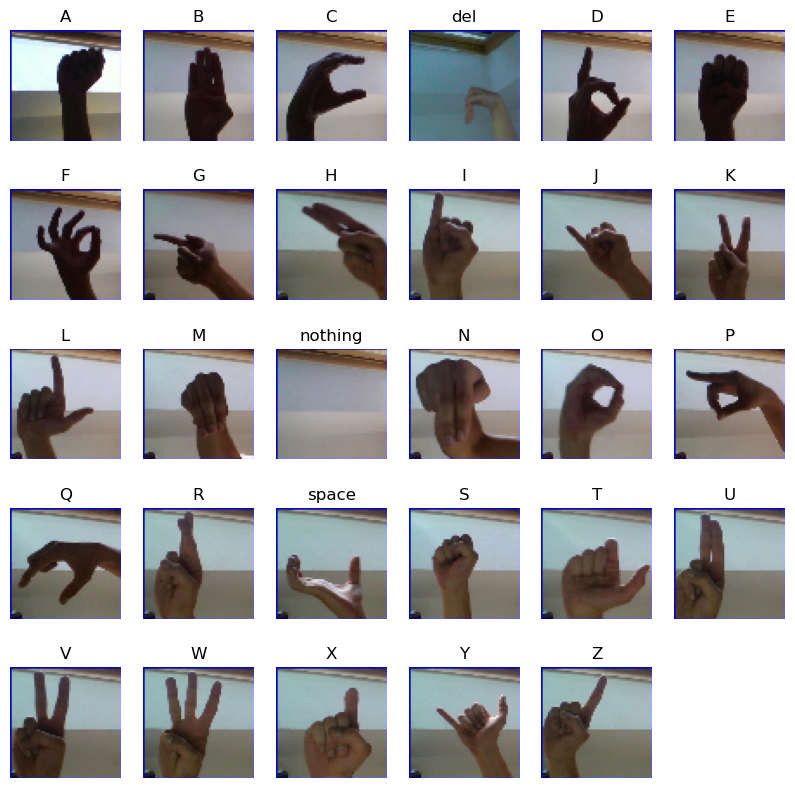

In [ ]:
# Plot Images test

test_dir = "./asl-alphabet/asl_alphabet_test/asl_alphabet_test/"
files_test = [f for f in os.listdir(test_dir)]
#print(sorted(files_test))
all_data_tests = [ test_dir + file for file in files_test]
df_test = pd.DataFrame(all_data_tests)
plt.figure(figsize=(10, 10))
i = 1
for img in all_data_tests:
    image = load_img(img, target_size = (64,64))
    ax = plt.subplot(5 , 6, i)
    plt.imshow(image)
    if i == 4:
        plt.title(labels[4])
    elif i == 5:
        plt.title(labels[3])
    elif i == 15:
        plt.title(labels[15])
    elif i == 16:
        plt.title(labels[14])
    elif i == 21:
        plt.title(labels[21])
    elif i == 22:
        plt.title(labels[20])
    else:
        plt.title(labels[i-1])

    plt.axis("off")
    i = i + 1
    if  i == 30:
        break
plt.show()

Repartition des donndonnées

In [ ]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

Redimensionnement


In [ ]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip = True, vertical_flip=False)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False   
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)

holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 62640 validated image filenames belonging to 29 classes.
Found 15660 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


# Model


In [ ]:
base_model = ResNet50V2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
base_model.trainable = False ## Not trainable weights

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
prediction_layer = layers.Dense(29, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    prediction_layer
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 29)                14877     
                                                                 
Total params: 27,774,493
Trainable params: 4,209,693
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [ ]:
classes = 29
epochs = 50
learning_rate = 0.0001

adam = Adam(learning_rate=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])

Epoch 1/50
490/490 [==============================] - 738s 1s/step - loss: 1.5638 - accuracy: 0.5344 - val_loss: 0.9406 - val_accuracy: 0.7305
Epoch 2/50
490/490 [==============================] - 723s 1s/step - loss: 1.3155 - accuracy: 0.6030 - val_loss: 0.7882 - val_accuracy: 0.7762
Epoch 3/50
490/490 [==============================] - 711s 1s/step - loss: 1.1724 - accuracy: 0.6424 - val_loss: 0.7058 - val_accuracy: 0.7942
Epoch 4/50
490/490 [==============================] - 710s 1s/step - loss: 1.0814 - accuracy: 0.6680 - val_loss: 0.6402 - val_accuracy: 0.8102
Epoch 5/50
490/490 [==============================] - 696s 1s/step - loss: 1.0152 - accuracy: 0.6866 - val_loss: 0.6113 - val_accuracy: 0.8158
Epoch 6/50
490/490 [==============================] - 696s 1s/step - loss: 0.9607 - accuracy: 0.7002 - val_loss: 0.5677 - val_accuracy: 0.8273
Epoch 7/50
490/490 [==============================] - 666s 1s/step - loss: 0.9098 - accuracy: 0.7157 - val_loss: 0.5518 - val_accuracy: 0.8324

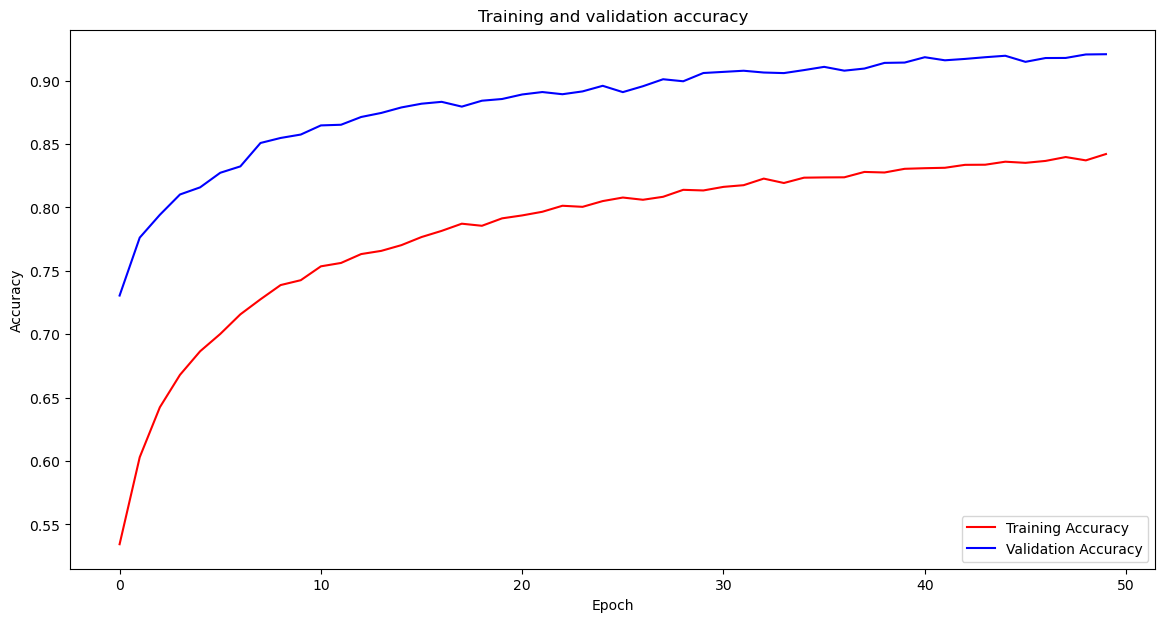

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

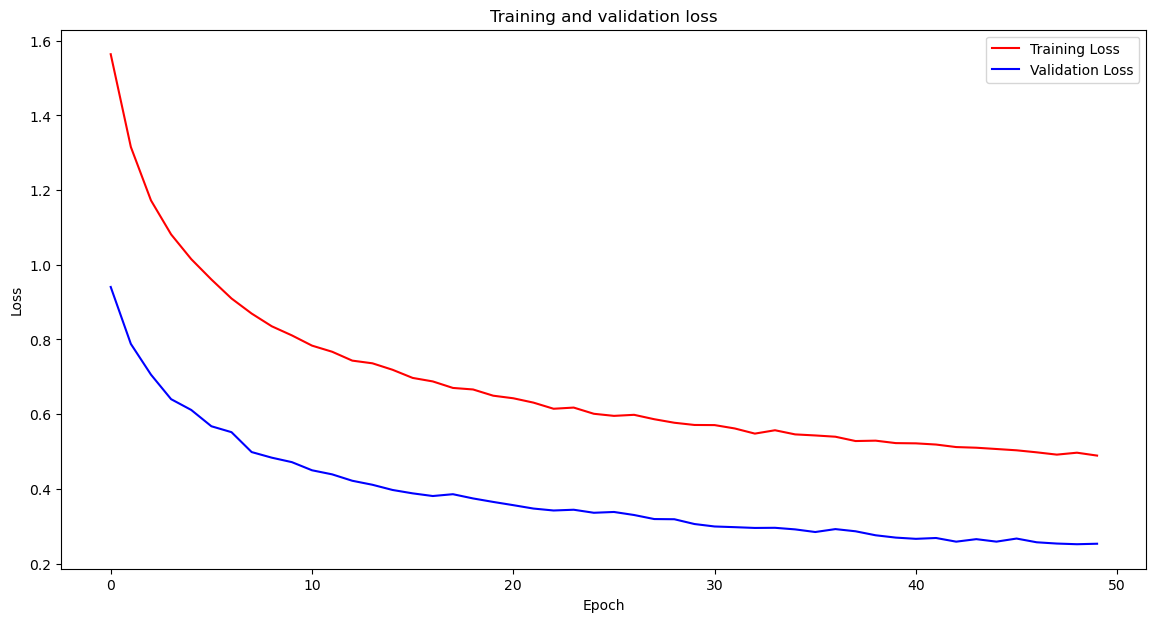

In [ ]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

68/68 [==============================] - 62s 884ms/step
              precision    recall  f1-score   support

           A       0.93      0.92      0.93       300
           B       0.89      0.98      0.93       300
           C       1.00      0.95      0.98       300
           D       0.96      0.97      0.97       300
           E       0.91      0.89      0.90       300
           F       0.98      0.97      0.97       300
           G       0.95      0.85      0.90       300
           H       0.95      0.95      0.95       300
           I       0.95      0.88      0.92       300
           J       0.98      0.98      0.98       300
           K       0.96      0.90      0.93       300
           L       0.98      0.97      0.97       300
           M       0.88      0.92      0.90       300
           N       0.94      0.88      0.91       300
           O       0.97      0.95      0.96       300
           P       0.96      0.94      0.95       300
           Q       0.95  

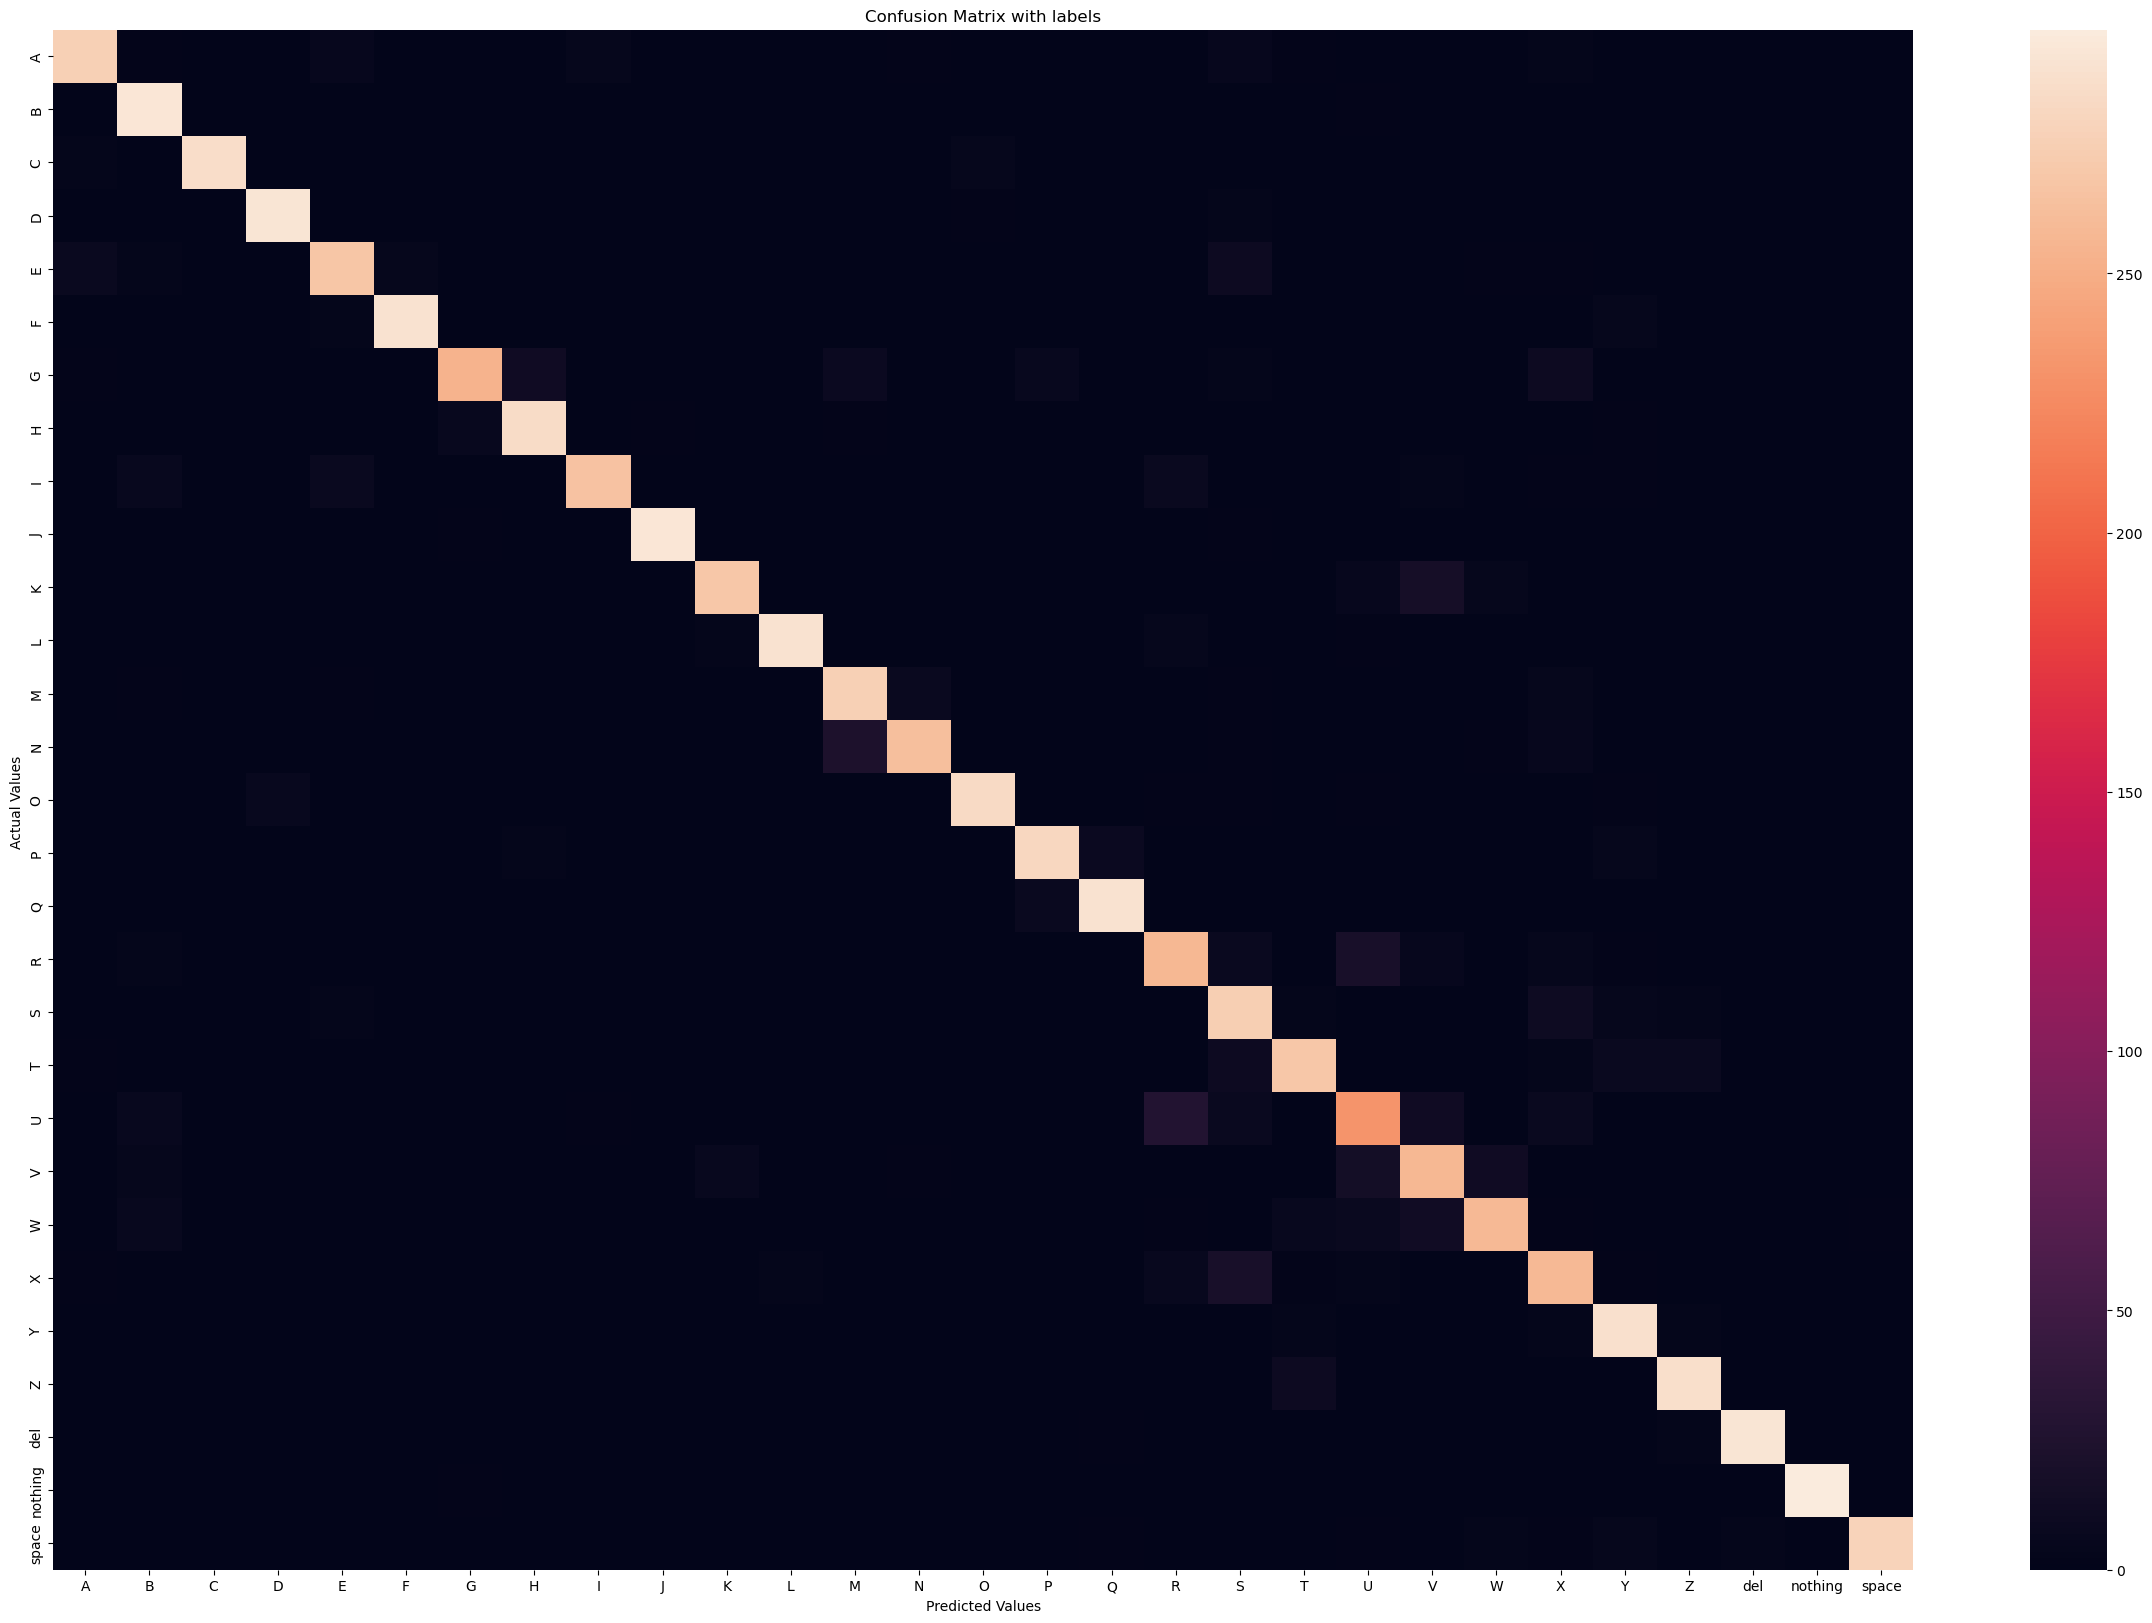

In [ ]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [ ]:
model_name = './model/ResNet50V2-asl-50e.h5'
model.save(model_name)

In [ ]:
json_model = model.to_json()

with open('ResNet50V2-asl-50e.json', 'w') as json_file:
    json_file.write(json_model)

In [ ]:
confusion = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[221   1   0   0  12   3   4   1   2   1   0   2   4   0   0   0   1   1
   20   6   0   1   2   4   2   7   3   0   2]
 [  4 210   0   0   8   0   0   5   4   3   2   0   3   2   5   0   0  19
    2   0  10   0   9   6   4   3   0   0   1]
 [  0   2 212   1   0   0   6   7   0   0   0   2   3   0   3   8  25   1
    4   0   0   0   0   1   4   1  10   1   9]
 [  0   3   7 237   0  10   1   0   4   1   7   3   1   0  11   0   1   4
    1   0   0   1   3   0   1   1   0   0   3]
 [ 20  12   0   4 141  11   7   2  12   0   4   4  12   7   0   0   0   1
   16  11   7   0   3  15   6   4   1   0   0]
 [  2   1   4   5   8 234   2   0   2   0   1   5   3   0   3   2   0   3
    6   1   0   0   5   1   7   5   0   0   0]
 [  4   3   1   0   0   0 224  13   0  14   1   0   1   0   0   0   5   1
    6   2   0   0   0  12   6   3   1   3   0]
 [  1   0   1   0   1   0  37 221   0  21   0   0   0   0   0   0   2   1
    2   0   0   0   0   1   3   0   2   4   3]
 [  3   7   0 

<AxesSubplot:>

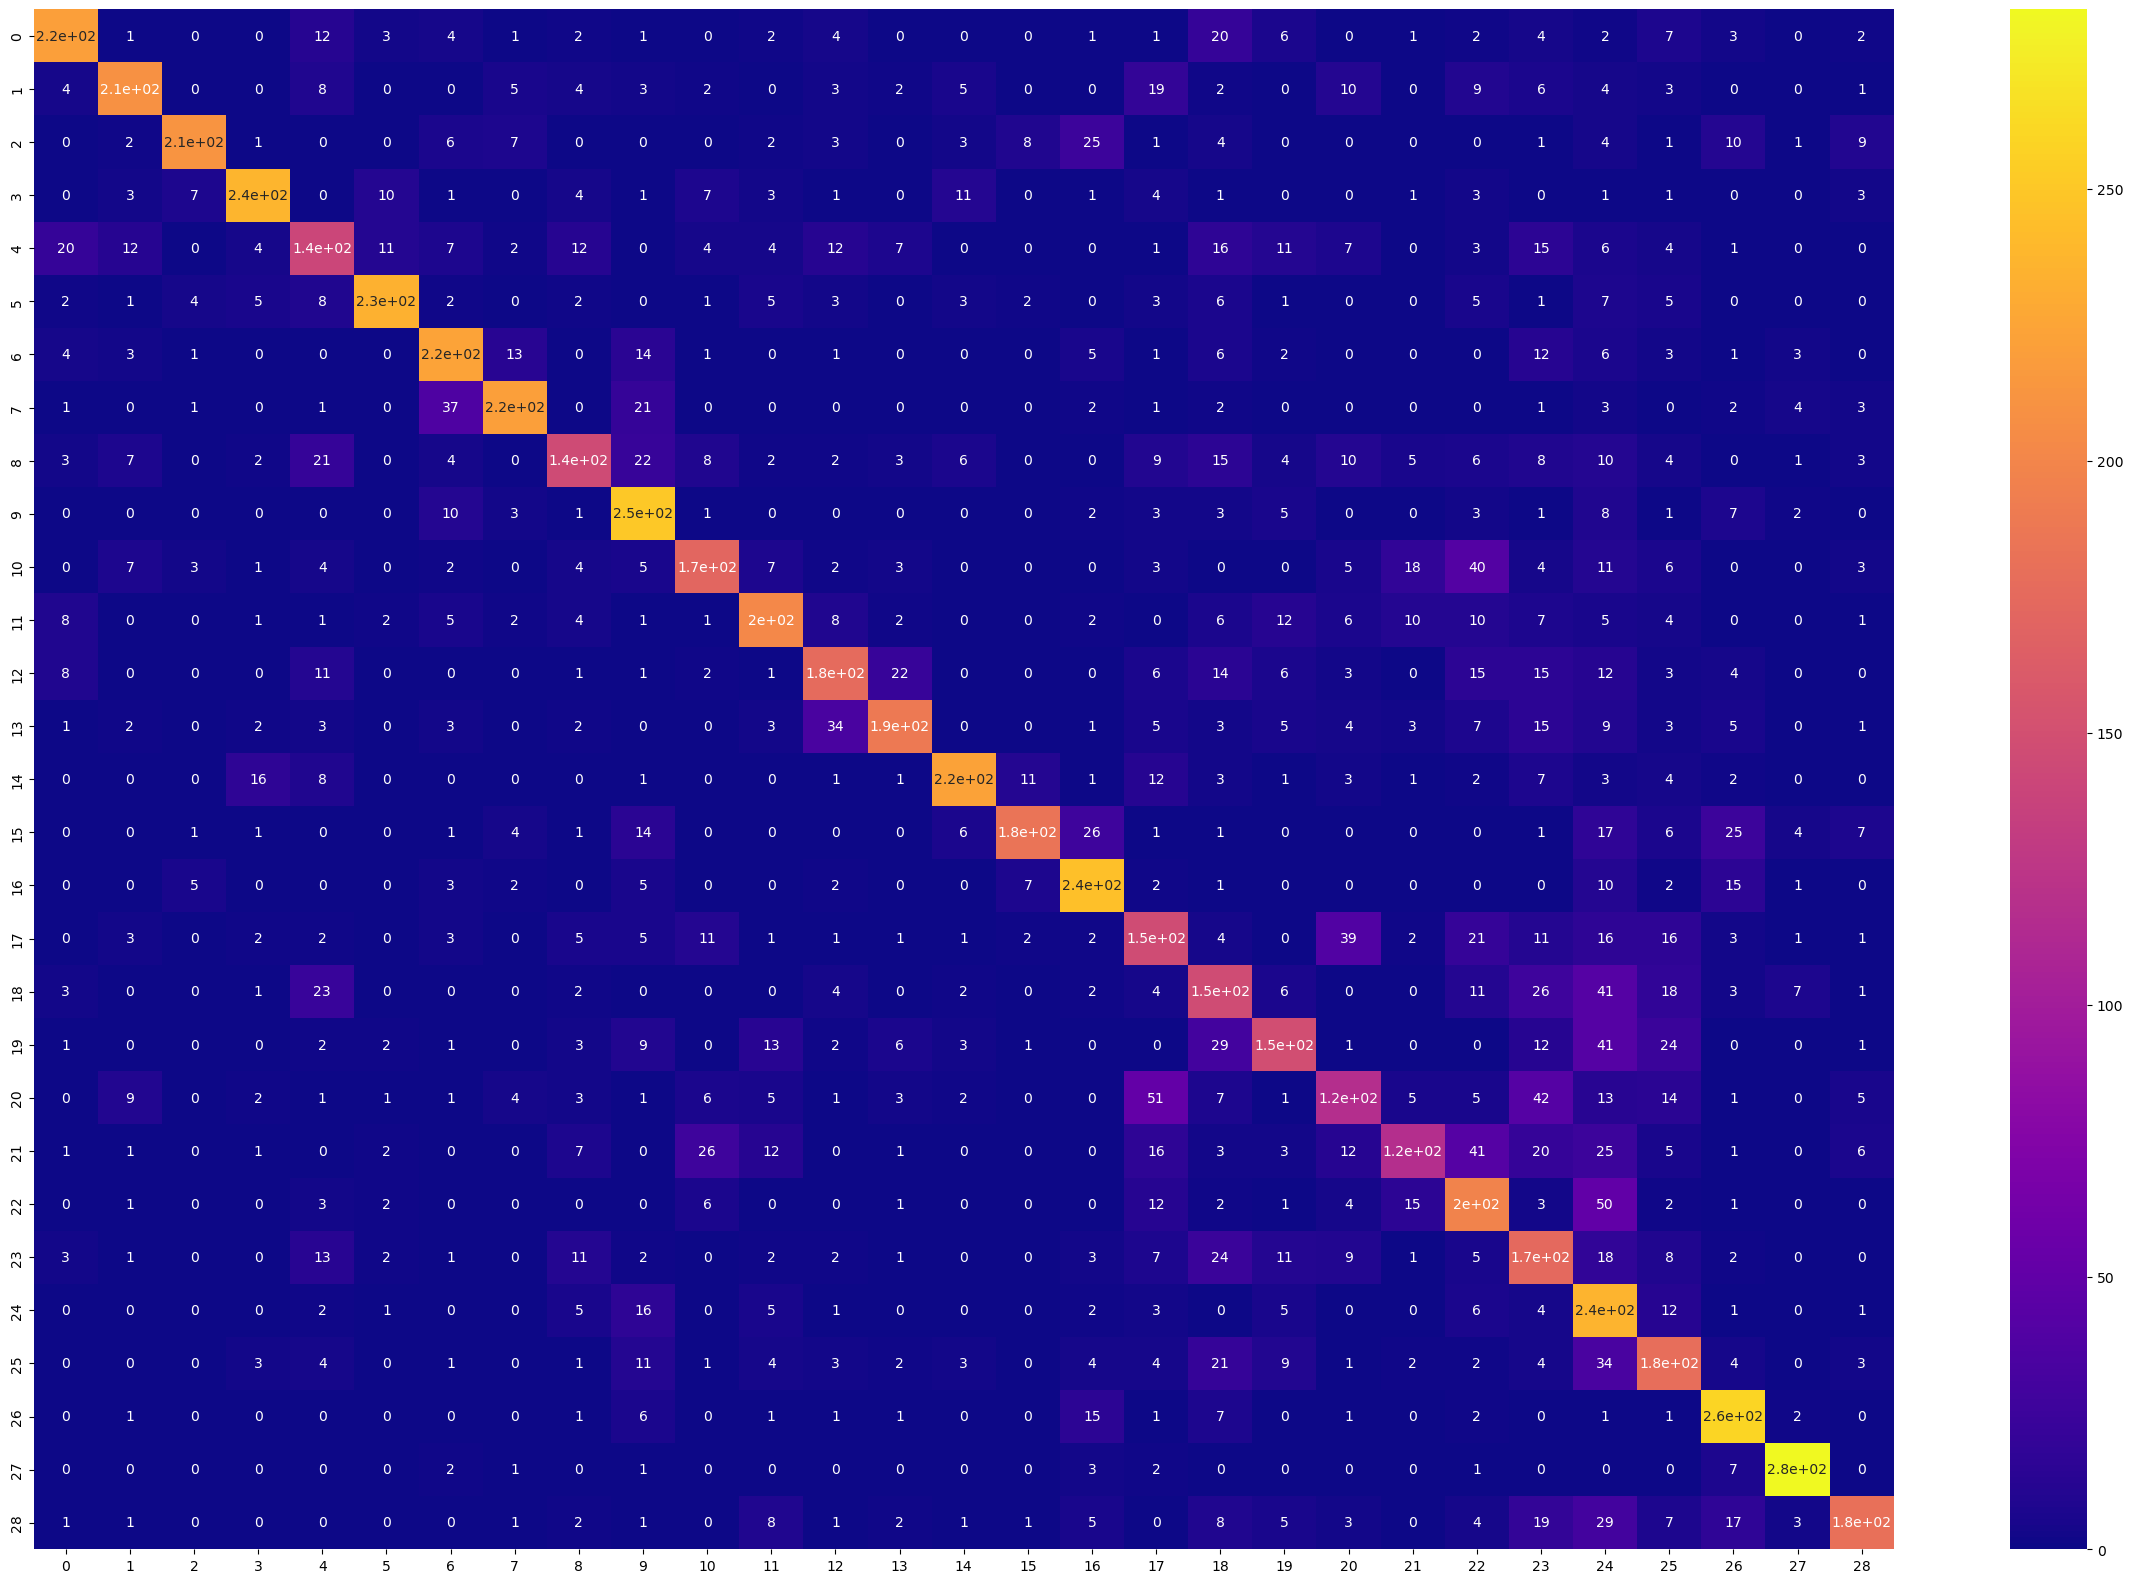

In [ ]:
plt.figure(figsize=(30, 20))
sns.heatmap(confusion, cmap="plasma", annot=True)

*Conclusion*


# Live Model

##  Test Predict

In [ ]:
# Load model
model_50 = models.load_model(model_name)

In [ ]:
filPath = './asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg'
image = load_img(filPath, target_size = (64,64))

In [ ]:
# convert image to array
transform_image = img_to_array(image)
transform_image.shape

(64, 64, 3)

In [ ]:
# Expand dimension
transform_image = np.expand_dims(transform_image, axis=0)
transform_image.shape

(1, 64, 64, 3)

In [ ]:
transform_image = preprocess_input(transform_image.copy())
transform_image = transform_image / 255.0

In [ ]:
prediction = model_50.predict(transform_image)
prediction

1/1 [==============================] - 1s 1s/step


array([[9.77738798e-01, 4.51363394e-06, 1.02725099e-10, 4.24051766e-10,
        4.27605445e-03, 2.14350749e-07, 1.30378304e-11, 6.12931147e-13,
        6.12126371e-07, 1.16440094e-10, 1.05775566e-09, 4.50340740e-04,
        7.00167194e-03, 7.70404353e-04, 1.39483545e-08, 1.00494058e-11,
        3.12265209e-12, 1.12462728e-09, 1.87080994e-03, 7.31593044e-03,
        8.40718712e-08, 8.23654531e-08, 3.82615628e-09, 5.68501127e-04,
        7.45724265e-07, 1.18427954e-06, 4.30725722e-09, 6.07342274e-15,
        1.29736699e-09]], dtype=float32)

In [ ]:

# decode predictions
labels[np.argmax(prediction)]

'A'

In [ ]:
# Enumerate all predictions
for i, p in enumerate(prediction[0]):
    print(f'p:{p*100:0.02f}% \t{labels[i]}')

p:97.77% 	A
p:0.00% 	B
p:0.00% 	C
p:0.00% 	D
p:0.43% 	del
p:0.00% 	E
p:0.00% 	F
p:0.00% 	G
p:0.00% 	H
p:0.00% 	I
p:0.00% 	J
p:0.05% 	K
p:0.70% 	L
p:0.08% 	M
p:0.00% 	N
p:0.00% 	nothing
p:0.00% 	O
p:0.00% 	P
p:0.19% 	Q
p:0.73% 	R
p:0.00% 	S
p:0.00% 	space
p:0.00% 	T
p:0.06% 	U
p:0.00% 	V
p:0.00% 	W
p:0.00% 	X
p:0.00% 	Y
p:0.00% 	Z


In [ ]:
# Predictions

## Live with opencv

In [ ]:
def predict(model,labels,frame):
    transform_image = img_to_array(image)
    transform_image = np.expand_dims(frame, axis=0)
    transform_image = preprocess_input(transform_image.copy())
    transform_image = transform_image / 255.0
    prediction = model.predict(transform_image)
    label = labels[np.argmax(prediction)]
    
    return label, np.max(prediction)*100

In [ ]:
# Load Model
model_2= models.load_model(model_name)

In [ ]:
# initiate video capture
cap=cv2.VideoCapture(0)
#saving all the captured frames to a video file called 'live prediction'
#out=cv2.VideoWriter(r'Downloads/VIDEOS.avi',cv2.VideoWriter_fourcc(*'MJPG'),10, (192*4,108*4)) 
if not cap.isOpened():
        print("Cannot open camera")
        exit()    
while(True):
    
    ret,img=cap.read() # grabbing each frame of webcam footage
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    img = cv2.resize(img,(192*4,108*4)) # resizing frame size, must match video output frame size
    cv2.rectangle(img, (32,32),(432,432),(0,255,0),2) # adding a rectangle to the image
    frame=cv2.resize(img[32:432,32:432],(64,64))
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    pred, percent = predict(model_2,labels,frame)
       
    #print(f'{pred}:\t {percent}') # live prediction of frame
    cv2.putText(img,'{} {:.2f}% res-net50V2'.format(pred,percent),(25,25),cv2.FONT_HERSHEY_SIMPLEX,0.9,(80,255,255),1)
    cv2.imshow('img', img) # output frame
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 136ms/step


# Transfert Learning

### Build model with weights pre-trained

In [ ]:
res_model = ResNet50V2(
    include_top = False,
    weights = 'imagenet',
    input_shape=(64, 64, 3)
)


In [ ]:
# freeze layers
for layer in res_model.layers[:143]:
    layer.trainable = False

In [ ]:
#to_res = (200, 200)
model = models.Sequential()
#model.add(layers.Lambda(lambda image: tf.image.resize(image, to_res))) 
model.add(res_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(29, activation='softmax'))



In [ ]:
check_point = callbacks.ModelCheckpoint(filepath="./model/ResNet50-TL.h5",
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )


In [ ]:
classes = 29
epochs = 10
learning_rate = 0.01
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
history = model.fit(train_generator, epochs=epochs, verbose=1,
                    validation_data=validation_generator,
                    shuffle=True,
                    callbacks=[check_point])
model.summary()


Epoch 1/10
490/490 [==============================] - 2863s 6s/step - loss: 2.7353 - accuracy: 0.1408 - val_loss: 2.0712 - val_accuracy: 0.2718
Epoch 2/10
490/490 [==============================] - 2947s 6s/step - loss: 1.6871 - accuracy: 0.3841 - val_loss: 1.1010 - val_accuracy: 0.5759
Epoch 3/10
490/490 [==============================] - 2889s 6s/step - loss: 1.1877 - accuracy: 0.5652 - val_loss: 0.6282 - val_accuracy: 0.7524
Epoch 4/10
490/490 [==============================] - 2898s 6s/step - loss: 0.9267 - accuracy: 0.6663 - val_loss: 0.4685 - val_accuracy: 0.8024
Epoch 5/10
490/490 [==============================] - 2772s 6s/step - loss: 0.7757 - accuracy: 0.7370 - val_loss: 0.3382 - val_accuracy: 0.8470
Epoch 6/10
490/490 [==============================] - 2667s 5s/step - loss: 0.6701 - accuracy: 0.7770 - val_loss: 0.3067 - val_accuracy: 0.8742
Epoch 7/10
490/490 [==============================] - 2675s 5s/step - loss: 0.6106 - accuracy: 0.8022 - val_loss: 0.2548 - val_accuracy:

### Export model and load 

In [ ]:
# Export model
model.save("./model/ResNet50-TL.h5")

In [ ]:
model_tl = models.load_model('./model/ResNet50-TL.h5')

### Metrics

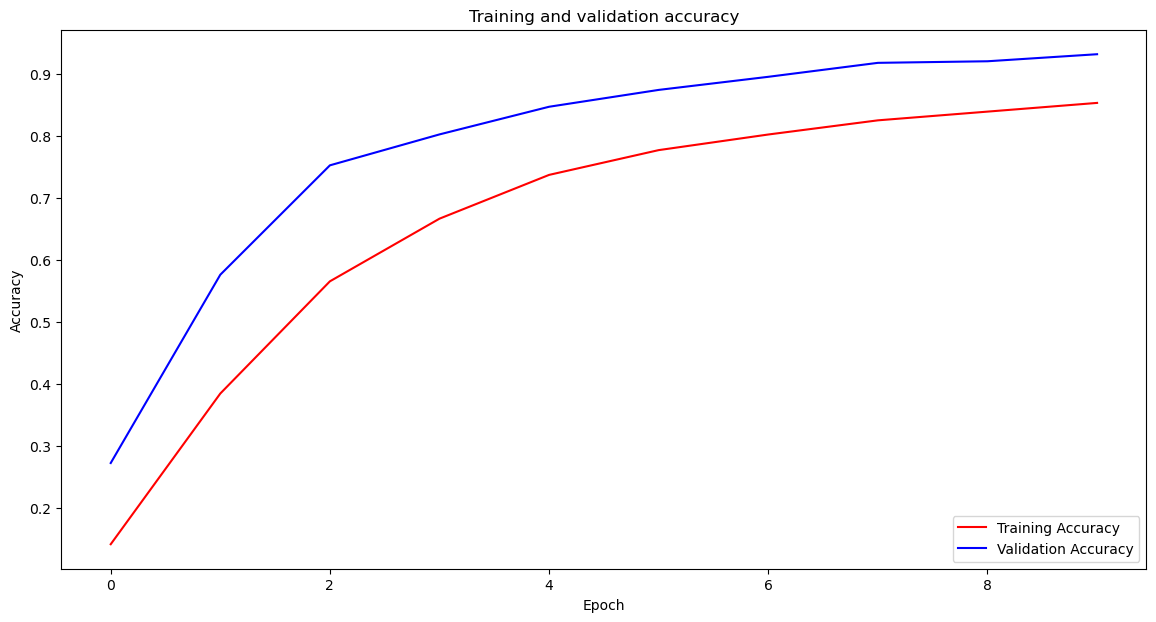

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

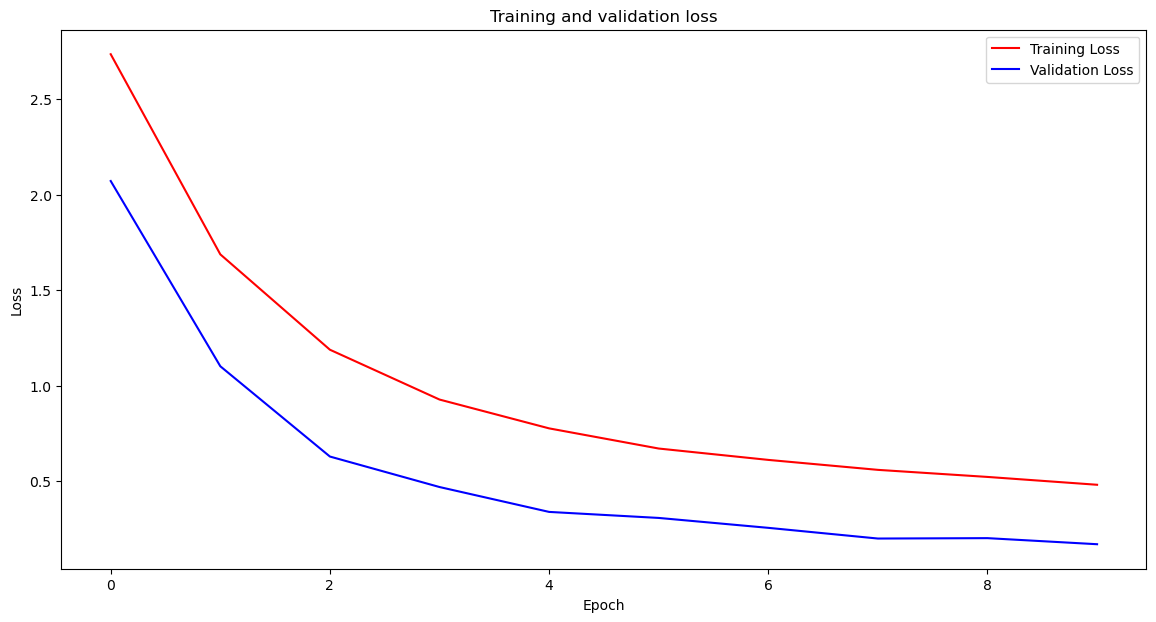

In [ ]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

68/68 [==============================] - 94s 1s/step
              precision    recall  f1-score   support

           A       0.96      0.97      0.97       300
           B       0.98      0.96      0.97       300
           C       1.00      1.00      1.00       300
           D       1.00      0.98      0.99       300
           E       0.99      0.91      0.95       300
           F       1.00      1.00      1.00       300
           G       0.98      0.99      0.98       300
           H       0.99      0.98      0.99       300
           I       0.99      0.93      0.96       300
           J       0.99      0.97      0.98       300
           K       0.98      0.91      0.94       300
           L       0.99      1.00      0.99       300
           M       0.60      0.01      0.02       300
           N       0.50      1.00      0.67       300
           O       0.98      0.99      0.99       300
           P       1.00      0.97      0.99       300
           Q       0.98     

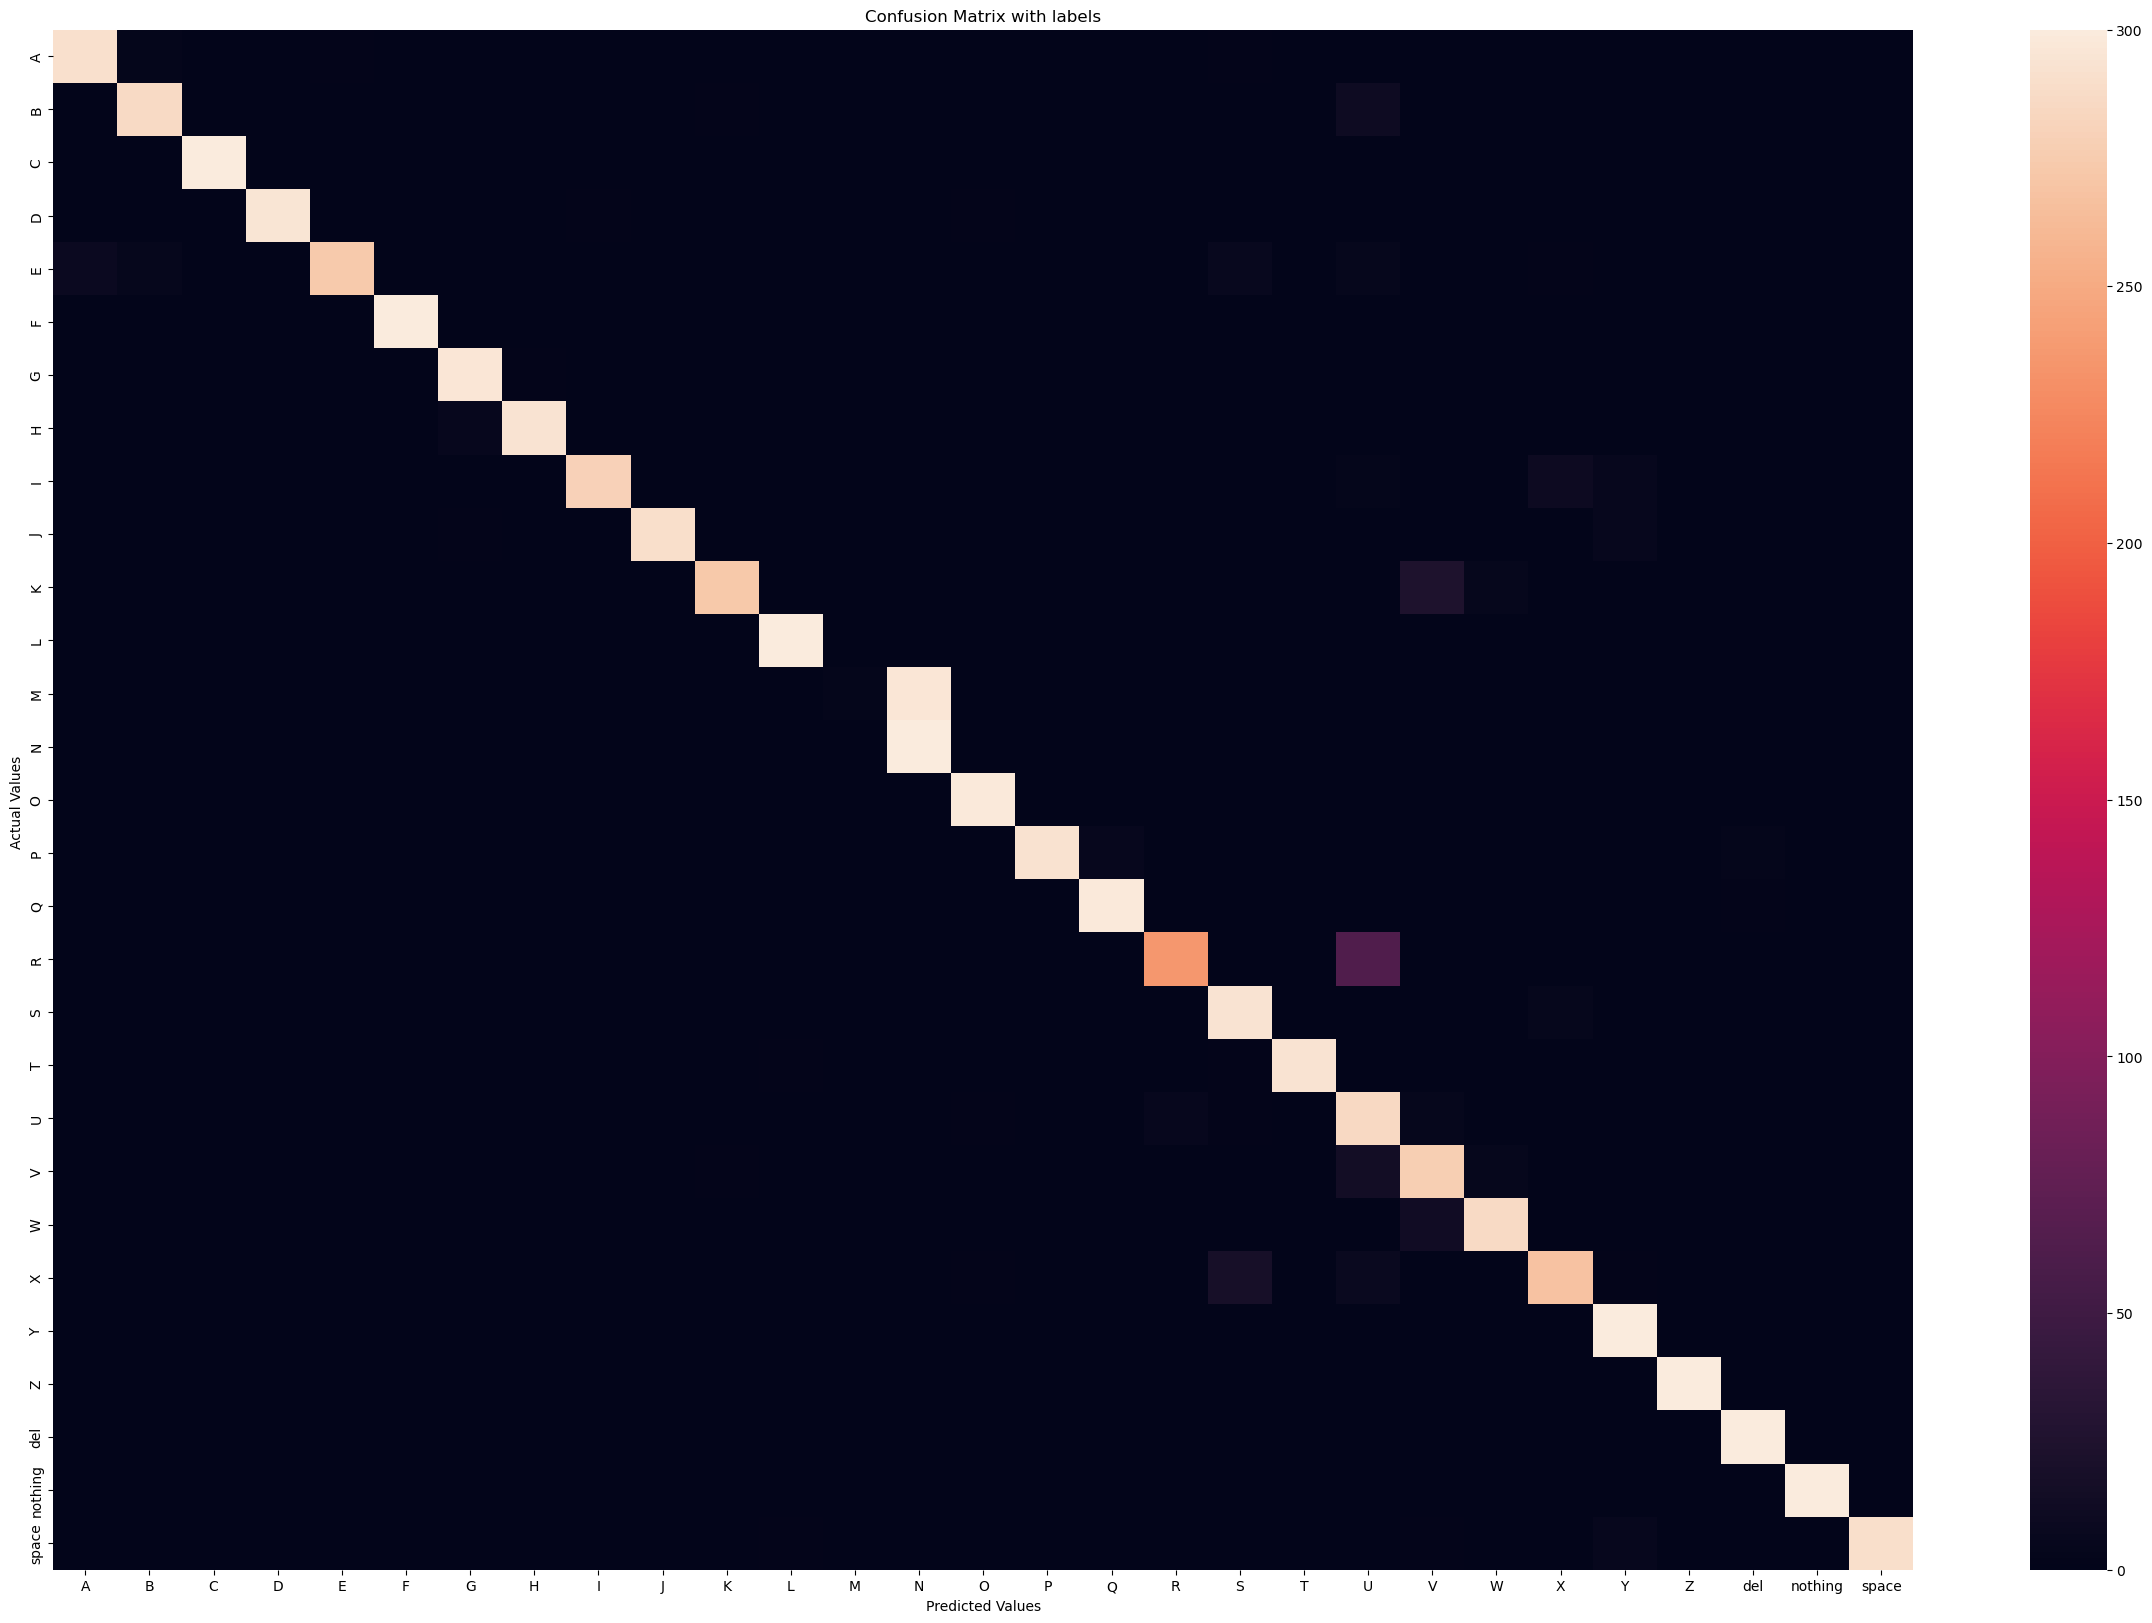

In [ ]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [ ]:
confusion = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[291   3   0   0   2   0   0   0   0   0   0   0   1   0   0   0   0   0
    2   0   0   0   0   1   0   0   0   0   0]
 [  0 287   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0   0  11   0   0   0   0   0   0   0   0]
 [  0   0 299   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 295   0   0   0   0   2   0   0   0   0   0   2   0   0   1
    0   0   0   0   0   0   0   0   0   0   0]
 [  9   4   0   0 274   0   0   0   0   0   0   0   0   0   0   0   0   0
    7   0   4   0   0   2   0   0   0   0   0]
 [  0   0   0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 296   2   0   1   0   0   0   0   0   0   0   0
    0   0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   5 294   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 

*Predictions*

In [ ]:
#

*Live with Opencv*